# 1. Clone ssd_keras repository. 

You should only need the custom layers (AnchorBoxes) and the custom loss function (ssd_loss.compute_loss) to load the model

Also to decode the model output (postprocessing+NMS) you need *decode_detections*

In [0]:
#Clone repository
!git clone https://github.com/henritomas/ssd-keras.git

Cloning into 'ssd-keras'...
remote: Enumerating objects: 1667, done.
remote: Counting objects: 100% (1667/1667), done.
remote: Compressing objects: 100% (590/590), done.
remote: Total 1667 (delta 1087), reused 1650 (delta 1070), pack-reused 0
Receiving objects: 100% (1667/1667), 24.79 MiB | 17.88 MiB/s, done.
Resolving deltas: 100% (1087/1087), done.


In [0]:
#Shift working directory to ssd-keras folder
%cd /content/ssd-keras

In [0]:
#Import necessary files/libraries
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.tensorflow_keras_ssd7 import build_model
from keras_loss_function.tensorflow_keras_ssd_loss import SSDLoss
from keras_layers.tensorflow_keras_layer_AnchorBoxes import AnchorBoxes
from ssd_encoder_decoder.ssd_output_decoder import decode_detections

from imageio import imread
from tensorflow.keras.preprocessing import image

# 2. Make sure to upload the tfkeras ssd7 *h5* model
```
model_path = '/content/insert_h5_model_here.h5'
```



In [0]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = '/content/tfkeras_ssd7_vocp.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})

# 3. Upload and process image to be predicted on

In [0]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

img_height=300
img_width=480

# We'll only load one image in this example.
img_path = '/content/silicon_valley.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

# 4. Make the prediction, decode it with `decode_detections`

In [0]:
y_pred = model.predict(input_images)

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.3,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=True,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded)

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[array([[  1.  ,   0.64,  92.9 ,  75.3 , 150.74, 236.17],
       [  1.  ,   0.37, 175.64,  64.73, 234.72, 206.17],
       [  1.  ,   0.36, 241.48,  63.72, 301.88, 192.61],
       [  1.  ,   0.36, 121.88,  63.53, 216.38, 250.91],
       [  1.  ,   0.3 , 100.64,  73.54, 161.43, 155.14]])]


# 5. Visualize our output on the original image.

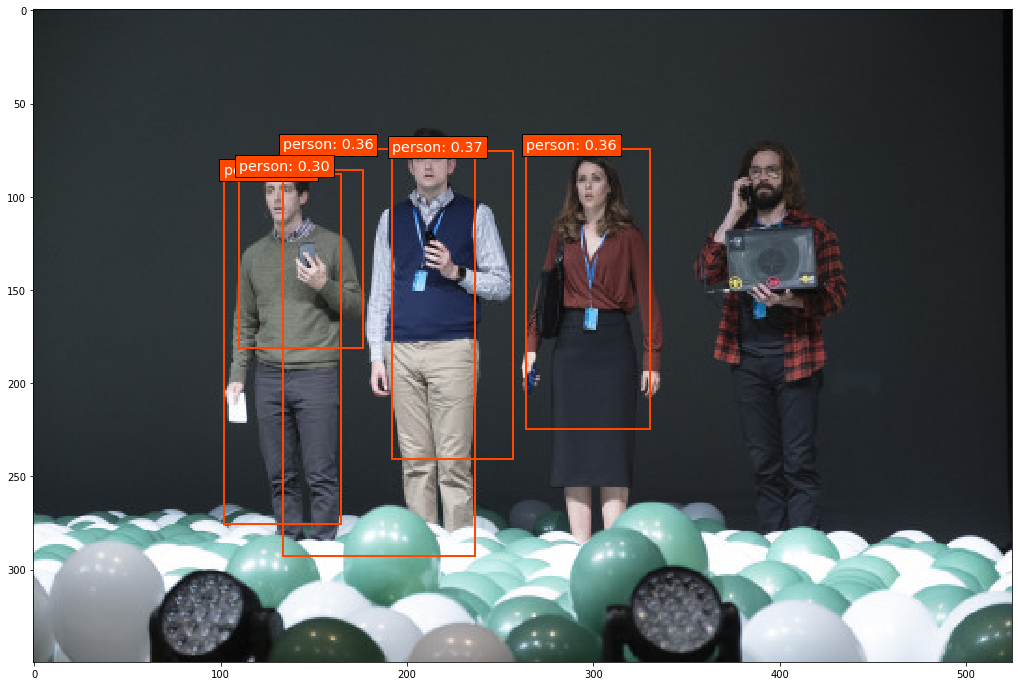

In [0]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background', 'person',]

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_decoded[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})